In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(100,100).view(-1,1,100,100)
        self._to_linear = None
        self.convs(x)
        
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256,29)

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # bc this is our output layer. No activation here.
        x = self.fc3(x)
        return F.softmax(x, dim=1)


net = Net()


In [18]:
import torch.optim as optim
training_data = np.load('initial_data.npy',allow_pickle=True)
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1,100,100)
X= X/255.0
y = torch.Tensor([i[1] for i in training_data])
VAL_PCT = 0.1 
val_size = int(len(X)*VAL_PCT)
print(val_size)

3000


In [19]:
train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X),len(test_X))

27000 3000


In [20]:
BATCH_SIZE = 32
EPOCHS = 10
for epoch in tqdm(range(EPOCHS)):
    for i in range(0,len(train_X),BATCH_SIZE):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,100,100)
        batch_y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)

100%|██████████| 10/10 [52:06<00:00, 312.62s/it]

tensor(2.5453e-06, grad_fn=<MseLossBackward>)


In [21]:
correct = 0 
total = 0 
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,100,100))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct+=1
        total+=1
    print('Accuracy:',round(correct/total,3))
            
    
    

100%|██████████| 3000/3000 [00:19<00:00, 151.96it/s]

Accuracy: 0.99


In [27]:
torch.save(net.state_dict(), 'initial_model')


data_set/asl_alphabet_test/H_test.jpg


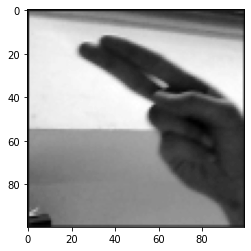

data_set/asl_alphabet_test/E_test.jpg


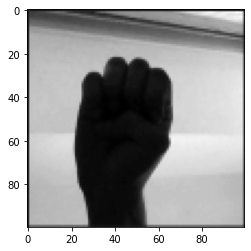

data_set/asl_alphabet_test/L_test.jpg


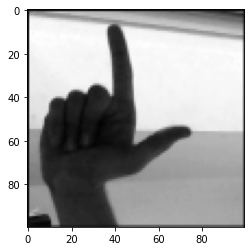

data_set/asl_alphabet_test/O_test.jpg


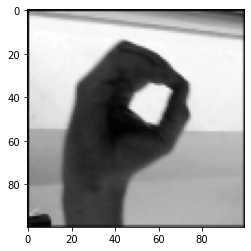

data_set/asl_alphabet_test/W_test.jpg


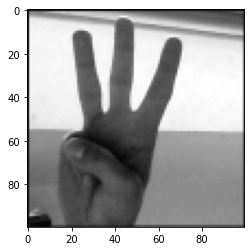

data_set/asl_alphabet_test/R_test.jpg


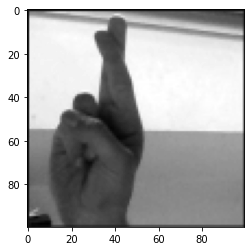

data_set/asl_alphabet_test/D_test.jpg


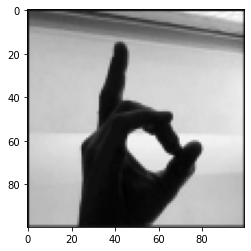

data_set/asl_alphabet_test/space_test.jpg


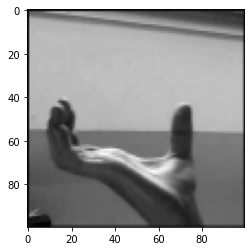

data_set/asl_alphabet_test/del_test.jpg


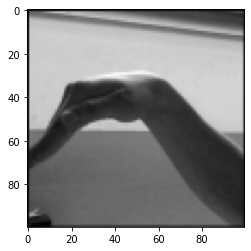

data_set/asl_alphabet_test/nothing_test.jpg


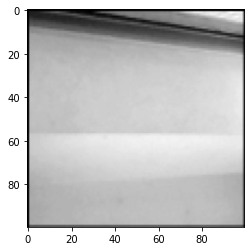

In [110]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
LABELS = {}
test_data = []
for i in enumerate(sorted(os.listdir('data_set/asl_alphabet_train'))):
    LABELS[i[1]]=i[0]
for i in ['H','E','L','O','W','R','D','space','del','nothing']:
    path = 'data_set/asl_alphabet_test/'+i+'_test.jpg'
    print(path)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (100,100))
    img = [np.array(img)/255]
    test_data.append([img,i])
    plt.imshow(img[0], cmap="gray")
    plt.show()
    

In [111]:
test_data[0][0]

[array([[0.10980392, 0.11764706, 0.11372549, ..., 0.10980392, 0.11372549,
         0.11372549],
        [0.11764706, 0.35294118, 0.35294118, ..., 0.20784314, 0.21568627,
         0.16862745],
        [0.10980392, 0.41568627, 0.40392157, ..., 0.1254902 , 0.12156863,
         0.11764706],
        ...,
        [0.11764706, 0.20392157, 0.2       , ..., 0.20784314, 0.20784314,
         0.15686275],
        [0.10980392, 0.10980392, 0.07058824, ..., 0.21176471, 0.20392157,
         0.16078431],
        [0.11764706, 0.09803922, 0.09019608, ..., 0.16078431, 0.16078431,
         0.14117647]])]

In [168]:
torch.save(net,'model_2')

In [28]:
model = Net()
model.load_state_dict(torch.load('initial_model'))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=29, bias=True)
)

In [112]:
X = torch.Tensor([i[0] for i in test_data]).view(-1,100,100)

In [113]:
LABELS2={}
for i in enumerate(['H','E','L','O','W','R','D','space','del','nothing']):
    LABELS2[i[0]]=i[1]

In [114]:
LABELS2

{0: 'H',
 1: 'E',
 2: 'L',
 3: 'O',
 4: 'W',
 5: 'R',
 6: 'D',
 7: 'space',
 8: 'del',
 9: 'nothing'}

In [115]:
X[0].shape

torch.Size([100, 100])

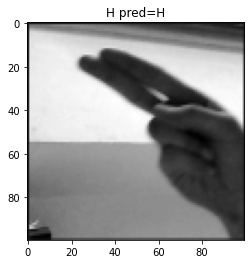

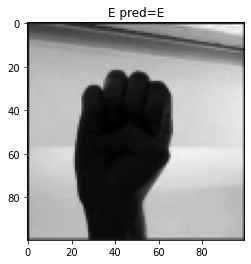

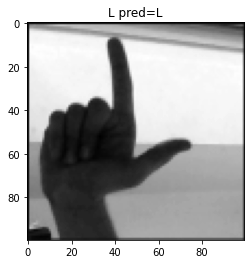

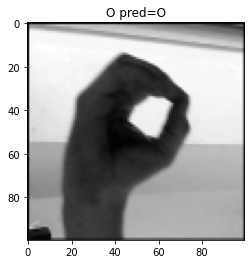

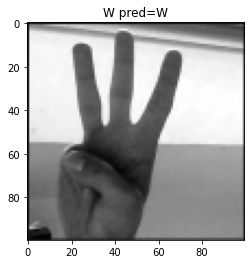

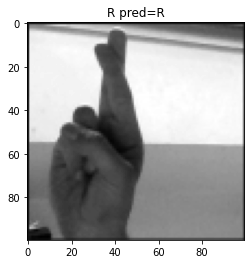

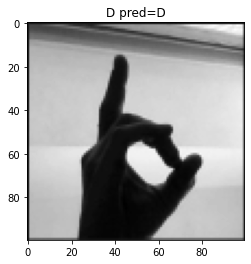

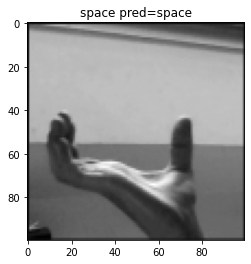

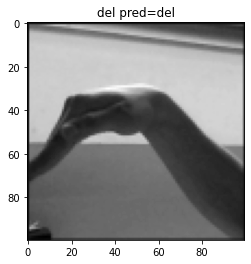

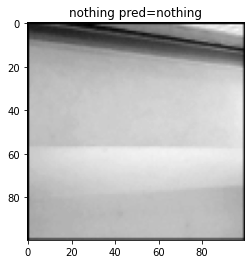

In [116]:
for i in range(len(LABELS2)):
    pred = torch.argmax(model(X[i].view(-1,1,100,100)))
    if pred == i:
        plt.imshow(test_data[i][0][0], cmap="gray")
        plt.title(test_data[i][1]+' ' + 'pred='+LABELS2[i])
        plt.show()